In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

- On fait fonction pour filtre les crises avec au moins 15 sec. 
- On fait une fonction LOO, input : data, non crise ou non patient
- On fait une fonction de score fichier à 5 secondes : 
    - sens
    - FPR
    - AUC   
.
- Random fields 


In [3]:
FEATURES_TIME_DURATION = 30
TRESHOLD_INCREMENTATION = 0.05

# Fonctions & csts

In [4]:
def define_datas_with_treshold(treshold):
    datas_file = '../../data/saved_features/saved_features_E{}.csv'.format(FEATURES_TIME_DURATION)
    datas = pd.read_csv(datas_file,index_col = 0)

    evt_bdg = pd.read_csv('../../data/preprocessing/simplified_evt.csv', index_col=0)

    datas['label'] = [int(i > treshold) for i in datas['label'].tolist()]
    patient = [sz[15:18] for sz in datas.evt_name.tolist()]
    datas['patient'] = patient

    '''
    features post treatment
    '''
    list_features_model = datas.columns.tolist()[3:-1]
    var_to_remove = ['spectre_MSG','spectre_MSD']
    for var in var_to_remove:
        list_features_model.remove(var)

    return datas, evt_bdg, list_features_model 

In [5]:
def train_test_from_sz(df,evt_name,col_model):
    '''
    return x_train, x_test, y_... 
    '''
    df_train = df[df.evt_name != evt_name]
    df_test = df[df.evt_name == evt_name]

    return df_train[col_model], df_test[col_model],df_train['label'], df_test['label']

def train_test_from_patient(df,patient,col_model):

    '''
    return x,y :
    - train on very patient but the selected
    - test on the selected patient
    '''

    df_train = df[df.patient != patient]
    df_test = df[df.patient == patient]

    return df_train[col_model], df_test[col_model],df_train['label'], df_test['label']
    
def loc_f1_score(tn, fp, fn, tp ):
    '''
    return f1 score from tn, fp, fn, tp
    '''
    loc_f1_score = 2 * ((tp/(tp+fp)) * (tp/(tp+fn))) / (tp / (tp + fp) + tp / (tp + fn))
    return(loc_f1_score)

def get_x_test_y_test(df,features):
    '''
    return x et y from dataframe
    '''
    x_test = df[features]
    y_test = df['label']
    
    return(x_test,y_test)

# Modelisation 

0. On fait un modèle de prédiction sur des fenêtres de 5 secondes. 
    0.0 TC

    0.1 > 15 sec. 
    
    0.2 Random fields 

In [6]:
def df_from_seizure_type(list_seizure,data,bdd):
    '''
    return a dataframe with only seizure of selected type
    input
    - list of seizure type
    output 
    - the dataframe
    - the list of sz
    '''
    list_sz = bdd[bdd.STY.isin(list_seizure)].filename.unique()
    list_sz = [i[:-4] for i in list_sz]
    data = data[data.evt_name.isin(list_sz)]
    list_sz = data.evt_name.unique()

    return(data,list_sz)

def filter_duration(datas, filter_sec):
    '''
    return a dataframe with only seizure longer than filter_sec
    '''
    list_sz = datas.evt_name.unique().tolist()
    list_ok_sz = []
    for sz in list_sz:
        toto = datas[datas.evt_name == sz]
        duration = np.sum(toto.label)
        if duration > filter_sec:
            list_ok_sz.append(sz)
    datas = datas[datas.evt_name.isin(list_ok_sz)]
    
    return(datas)

In [7]:
treshold = 0.0

while treshold < 1.0:
    datas, evt_bdg, list_features_model = define_datas_with_treshold(treshold);
    data_tc, list_tc = df_from_seizure_type(['TC'], datas, evt_bdg)
    
    '''
    on insctancie un nouveau modèle de forêt aléatoire
    '''
    rfc = RandomForestClassifier(max_depth = 3, n_estimators = 5, max_features = 20)


    list_for_model = list_tc
    columns_score = ['evt_name', 'sens', 'spec', 'fn', 'fp', 'tn', 'tp']
    df_score = pd.DataFrame(columns = columns_score)

    i = 0
    for sz in list_for_model:
        x_train, x_test, y_train, y_test = train_test_from_sz(datas, sz, list_features_model)
        '''
        J'entraine mon modèle sur x_train, y_train
        '''
        rfc.fit(x_train,y_train)
        y_pred = rfc.predict(x_test)
        y_pred_proba = rfc.predict_proba(x_test)
        y_pred_proba = y_pred_proba[:,1]

        try:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
        except:
            sens, spec, fn, fp, tn, tp = np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN
            print('exception')

        df_score.loc[sz] = [sz, sens, spec, fn, fp, tn, tp] 

    fp_glob = df_score.fp.sum()
    fn_glob = df_score.fn.sum()
    tp_glob = df_score.tp.sum()
    tn_glob = df_score.tn.sum()
    sens_glob = tp_glob / (tp_glob + fn_glob)
    spec_glob = tn_glob / (tn_glob + fp_glob)
    print('Treshold = ', treshold, ' Sensibilité = ', sens_glob, ' Spécificité = ', spec_glob)

    '''
    Sauvegarde de la features importance en fonction du treshold
    '''
    plt.figure(figsize=(10, 20))
    plt.barh(list_features_model, rfc.feature_importances_)
    plt.savefig('../../data/saved_scores/features_importance_E{}_treshold_{}.jpg'.format(FEATURES_TIME_DURATION, treshold))
    plt.close()

    treshold = round(treshold + TRESHOLD_INCREMENTATION, 2)


Treshold =  0.0  Sensibilité =  0.7  Spécificité =  0.9466666666666667
Treshold =  0.05  Sensibilité =  0.6949152542372882  Spécificité =  0.9513274336283186
Treshold =  0.1  Sensibilité =  0.6495726495726496  Spécificité =  0.9492273730684326
Treshold =  0.15  Sensibilité =  0.6434782608695652  Spécificité =  0.9472527472527472
Treshold =  0.2  Sensibilité =  0.6814159292035398  Spécificité =  0.9474835886214442
Treshold =  0.25  Sensibilité =  0.6517857142857143  Spécificité =  0.9585152838427947
Treshold =  0.3  Sensibilité =  0.6272727272727273  Spécificité =  0.9717391304347827
Treshold =  0.35  Sensibilité =  0.5925925925925926  Spécificité =  0.9761904761904762
Treshold =  0.4  Sensibilité =  0.5794392523364486  Spécificité =  0.9762419006479481
Treshold =  0.45  Sensibilité =  0.5943396226415094  Spécificité =  0.9827586206896551
Treshold =  0.5  Sensibilité =  0.6444444444444445  Spécificité =  0.9854166666666667
Treshold =  0.55  Sensibilité =  0.6136363636363636  Spécificité

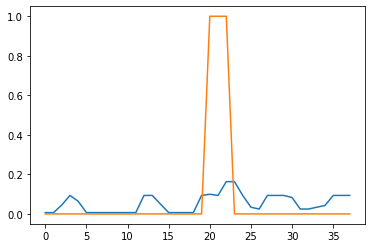

In [ ]:
abs = range(len(y_pred))
plt.plot(abs,y_pred_proba)
plt.plot(abs,y_test)

## Graph

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


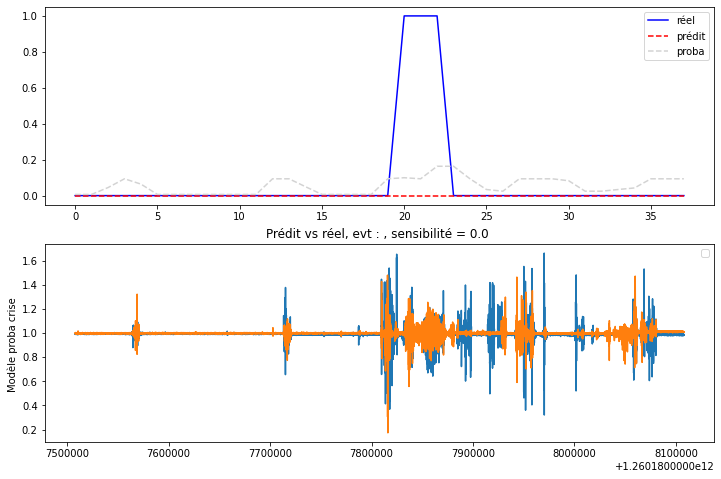

In [ ]:
dir_graph_files = '../../data/filtered_and_labeled_evt'
df_graph = pd.read_csv(dir_graph_files + '/' + sz + ('.csv'),index_col = 0)

fig , ax = plt.subplots(2,1,figsize = (12,8))
ax[0].plot(y_test,label = 'reel',color = 'blue')
ax[0].plot(y_pred,'--', label = 'prédit',color = 'red')
ax[0].plot(y_pred_proba,'--', label = 'prédit proba',color = 'lightgrey')
ax[0].legend(['réel','prédit','proba'])
ax[1].plot(df_graph.timeline,df_graph.MSG)
ax[1].plot(df_graph.timeline,df_graph.MSD)
plt.legend()
plt.title('Prédit vs réel, evt : , sensibilité = {} '.format(sens))
plt.ylabel('Modèle proba crise ') 
plt.show()